# MNE tutorial for eeg pipeline from data import to classifier evaluation

In this tutorial, we aim to show the rest of the team how to make a basic EEG pipeline. At the end, some additional resources are listed as important reading materials to supplement the excercise, as well as interesting tools that might be usefull in a real time EEG BCI.

## Data source
The data we will use in this demonstration was taken from the work of *Kang et. al.*, which is available at [this database article.](https://www.sciencedirect.com/science/article/pii/S2352340921007496?via%3Dihub) The data itself can be downloaded (here)[https://data.mendeley.com/datasets/4r8hp2hmb4/5].

We strongly suggest you read the entire database paper before continuing, as it will contextualize the follwoing steps and data structures that we willd evelop hroughout the excercise.

## Requirements
below, you will find the needed installations you will need to make in order to be able to run this code. If you do not have the *pip install* function available in your system, you must first enable it before continuing.

Remember that in python using the symbol "!" tells the interpreter to read the command as if it were accessed directly to the terminal as a bash command.

In [1]:
!pip install mne
!pip install pandas
!pip install numpy
!pip install mne-icalabel
!pip install os
!pip install scipy
!pip install matplotlib
!pip install torch

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [1]:
# now, import these modules into your code
''' here, we use the wide-spread standard for 
    pandas and numpy library '''
import numpy as np
import pandas as pd
import mne
import os
import scipy
import matplotlib.pyplot as plt
import torch
# you can read more documentation about this
# extension for mne at: 
# https://github.com/mne-tools/mne-icalabel/blob/main/examples/00_iclabel.py
from mne_icalabel import label_components

## Functions
These functions help make the rest of the code mor readable and streamlined. They also allow for modularized code that can be more easily optimized, improved, and updated. As a rule of thumb, try to use functions and classes, when applicable, to make your code easier to read and maintain.

In [22]:
# function to create eeg_raw objects
def import_eeg_raw(path):
    ch_names = ['P4','O2','P8','T8','C4','Cz','Fz','F4','Fp2','F8','Fp1','F7','F3','C3','T7','P7','P3','O1','Pz'];
    sfreq = 250;
    # create info instance to create eeg mne object
    eeg_info = mne.create_info(ch_names, sfreq, ch_types='eeg', verbose=None);
    
    #path to eeg
    eeg_pandas = pd.read_csv(path, delimiter=";");
    eeg_pandas=eeg_pandas.fillna(0).transpose();
    
    #create eeg object
    eeg_raw = mne.io.RawArray(eeg_pandas, eeg_info);
    
    # Use the preloaded montage for the 10-20 system.
    montage_1020 = mne.channels.make_standard_montage("standard_1020",head_size='auto');
    eeg_raw.set_montage(montage_1020);
    return eeg_raw

# function to save to a csv
def preprocessed_eeg_to_csv(eeg_data, path):
    # Convert the RawArray data to a pandas DataFrame
    df = pd.DataFrame(data=eeg_data.get_data().T, columns=eeg_data.ch_names);

    path = path.replace("data_porn_addiction\\raw", "data_porn_addiction\\preprocessed");
    # Extract the directory path
    directory_path = os.path.dirname(path);
    # Create the directory if it doesn't exist
    os.makedirs(directory_path, exist_ok=True);
    # Save the DataFrame to a CSV file
    df.to_csv(path, index=False);
    print(f'file: {path} --- has been written')
    return
# files into an organized structure (dictionary)
def get_csv_paths_by_subfolder(root_folder):
    csv_paths_by_subfolder = {};

    # Walk through the directory tree
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            # Check if the file has a .csv extension
            if file.endswith('.csv'):
                # Get the name of the subfolder
                subfolder_name = os.path.basename(root);
                
                # Construct the full path to the CSV file
                csv_path = os.path.join(root, file);

                # Append the CSV path to the subfolder's list in the dictionary
                if subfolder_name not in csv_paths_by_subfolder:
                    csv_paths_by_subfolder[subfolder_name] = [];
                csv_paths_by_subfolder[subfolder_name].append(csv_path);

    return csv_paths_by_subfolder

# Function to apply ICA and select non-artifact components
def apply_ica(eeg_raw_data):
    # eeg_raw_data must have completely defined attributes for 
    # montage, channel names, and sampling frequency
    
    # filter to remove slow drift    
    filt_raw = eeg_raw_data.copy().filter(l_freq=1.0, h_freq=100.0);
 
    # Before fitting ICA, we will apply a common average referencing, to comply
    # with the ICLabel requirements.
    filt_raw = filt_raw.set_eeg_reference("average");
    
    # look into what the fit_params argument does
    ica = mne.preprocessing.ICA(n_components=None, max_iter="auto", random_state=97,method='infomax', fit_params=dict(extended=True));
    
    ica.fit(filt_raw);
    # ica
    
    ic_labels = label_components(filt_raw, ica, method="iclabel");
    # We can extract the labels of each component and exclude
    # non-brain classified components, keeping 'brain' and 'other'.
    # "Other" is a catch-all that for non-classifiable components.
    # We will stay on the side of caution and assume we cannot blindly remove these.   
    labels = ic_labels["labels"];
    exclude_idx = [idx for idx, label in enumerate(labels) if label not in ["brain", "other"]];

    # Now that the exclusions have been set, we can reconstruct the sensor signals
    # with artifacts removed using the `~mne.preprocessing.ICA.apply` method
    # (remember, we're applying the ICA solution from the *filtered* data to the
    # original *unfiltered* signal). Plotting the original raw data alongside the
    # reconstructed data shows that the heartbeat and blink artifacts are repaired.
    
    # ica.apply() changes the Raw object in-place, so let's make a copy first:
    reconst_raw = eeg_raw.copy();
    print(exclude_idx);
    reconst_raw = ica.apply(reconst_raw, exclude=exclude_idx);
    return reconst_raw

# function to create eeg_raw objects
def import_preprocessed_signals(path, channels):
    #ch_names = ['P4','O2','P8','T8','C4','Cz','Fz','F4','Fp2','F8','Fp1','F7','F3','C3','T7','P7','P3','O1','Pz'];

    #path to eeg
    eeg_pandas = pd.read_csv(path, usecols=channels, delimiter=",");
    eeg_pandas=eeg_pandas.fillna(0);
    
    return eeg_pandas

# Function to apply bandpass filter to a vector/signal
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs;
    low = lowcut / nyquist;
    high = highcut / nyquist;
    b, a = scipy.signal.butter(order, [low, high], btype='band');
    filtered_data = scipy.signal.filtfilt(b, a, data);
    return filtered_data

# map a filter function to every column of a pd.dataframe
def eeg_apply_filter(data,lowcut, highcut, fs):
    #initialize the df to store the filtered signals
    filtered_signal = pd.DataFrame({});
    for column in data.columns:
        filtered_signal[column] = bandpass_filter(data[column].values, lowcut, highcut, fs);
    return filtered_signal



## Preprocessing

### Baseline Correction and artifact removal with ICA
First, for each subject we calculate the average value for the basal state, defined as the average of the respective averages per channel of the eyes-open and eyes-closed files per subject. 

Then, these vectors are substracted for each reading from the rest of the eeg files.

Finally, each corrected file is decomposed into its ICA components and only 'brain' and 'other' components are used for the signal reconstruction. The result is a file structure where a subfolder named preprocessed_subjects, which mirrors the root_folder structure, contains 5 files for each subject, the result of this first pipeline.

It should be noted that this is done in a modular fashion, so the reader may very well choose to ommit any or all of these transformations to compare the results.

In [4]:
# directory where you unzipped the eeg files
root_folder = "/Users/monica/Documents/data_porn_addiction"; # Replace this with the path to your root folder
output_path = "/Users/monica/Documents/data_porn_addiction_prepocessed"
# get all the directories into a {subject: [file1,file2]} structure
csv_paths_by_subject = get_csv_paths_by_subfolder(root_folder);

for subject, files in csv_paths_by_subject.items(): # for each subject
    
    # sepparate file paths for base_line removal
    baseline_paths = [item for item in files if 'EC.csv' in item or 'EO.csv' in item];
    eeg_paths = [item for item in files if 'EC.csv' not in item and 'EO.csv' not in item];
    
    ec = import_eeg_raw(baseline_paths[0]); # import EC
    eo = import_eeg_raw(baseline_paths[1]); # import EO
    ec_averages = np.mean(ec._data, axis=1); # calculate EC average
    ec_averages = np.mean(ec._data, axis=1); # calculate EO average
    baseline = (ec_averages + ec_averages) / 2; # calculate baseline average

    for file in eeg_paths : # for each file excluding EC and EO
        print(f'file:{file} --- opened')
        
    # remove baseline
        eeg_raw = import_eeg_raw(file); # import the eeg file
        eeg_raw._data = eeg_raw._data - baseline[:, np.newaxis]; # remove baseline

    # ICA decomposition adn artifact removal
        reconstructed_eeg = apply_ica(eeg_raw);

    # Notch filter
        filtered_eeg = reconstructed_eeg.copy().notch_filter(freqs=np.arange(55, 66), filter_length=6000, phase='zero');

    # save to new nested structure
        subject_folder = os.path.join(output_path, subject)
        os.makedirs(subject_folder, exist_ok=True)  # Create the subject folder if it doesn't exist

        name_out = os.path.basename(file)  # Get the file name
        path_out = os.path.join(subject_folder, name_out)

        preprocessed_eeg_to_csv(filtered_eeg, path_out)

    
    


Creating RawArray with float64 data, n_channels=19, n_times=15003
    Range : 0 ... 15002 =      0.000 ...    60.008 secs
Ready.
Creating RawArray with float64 data, n_channels=19, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
file:/Users/monica/Documents/data_porn_addiction/S5/C.csv --- opened
Creating RawArray with float64 data, n_channels=19, n_times=15004
    Range : 0 ... 15003 =      0.000 ...    60.012 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 8

## Processing

### Loading preprocessed data and extracting relevant channels
Based on a basic literature overview in Scopus, we decided to use only the frontal and prefrontal electrodes going forth, since they correlate the most with the prefrontal cortex, which is the cortical structure that we expect to differ between addict and non-addict users

In [24]:
# channels of interest pertaining to prefrontal and frontal areas.
ch_names = ['Fz','F4','Fp2','F8','Fp1','F7','F3'];

# directory where you stored preprocessed files
preprocessed_folder = "/Users/monica/Documents/data_porn_addiction_prepocessed"; # Replace this with the path to your root folder

# get all the directories into a {subject: [file1,file2]} structure
csv_paths_by_subject = get_csv_paths_by_subfolder(preprocessed_folder);
path=csv_paths_by_subject['S1'][0];
eeg_prepro_test = import_preprocessed_signals(path,ch_names);


### Feature extraction 

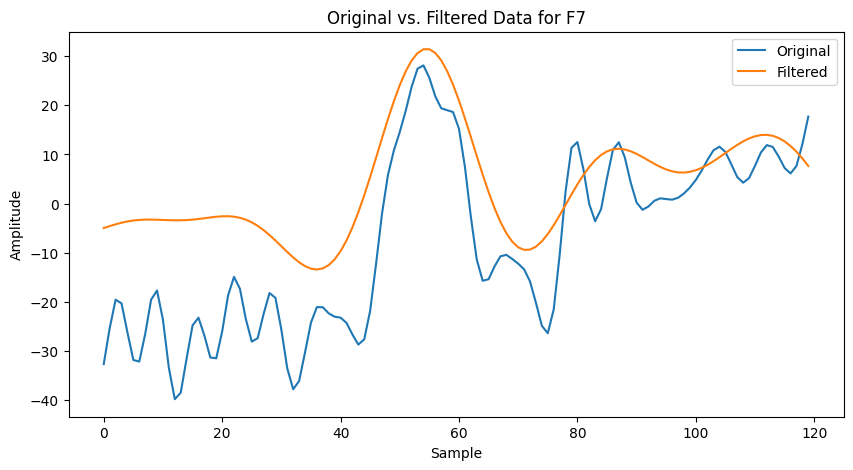

In [25]:
# Define filter parameters
lowcut = 1.0;  # Lower cutoff frequency in Hz
highcut = 10.0;  # Upper cutoff frequency in Hz
fs = 250.0;  # Sampling frequency in Hz
eeg_band = eeg_apply_filter(eeg_prepro_test,lowcut, highcut, fs);

# Plot original and filtered data for one electrode as an example
electrode_name = 'F7'
plt.figure(figsize=(10, 5))
plt.plot(eeg_prepro_test.loc[range(0,120),electrode_name], label='Original')
plt.plot(eeg_band.loc[range(0,120),electrode_name], label='Filtered')
plt.title(f'Original vs. Filtered Data for {electrode_name}')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.show()



## Classifiers A-D